# Replication assignment

Replicate the results found in [Bryant et al  (2010)](https://doi.org/10.1016/j.techfore.2009.08.002), [Rozenberg et al (2014)](https://link.springer.com/content/pdf/10.1007/s10584-013-0904-3.pdf), and [Hamarat et al (2013)](https://doi.org/10.1016/j.techfore.2012.10.004). The data files are named accordingly. You can also look at [Kwakkel & Jaxa-Rozen (2016)](https://www.sciencedirect.com/science/article/pii/S1364815215301092), which gives a succint summary of these three cases. 

An additional useful, if dated, resource for Bryant et al is https://waterprogramming.wordpress.com/2015/08/05/scenario-discovery-in-python/ 



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time 

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome,ArrayOutcome, perform_experiments,
                            ema_logging)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel


#from ema_workbench import Samplers
# from ema_workbench.analysis.plotting import lines, Density
# from ema_workbench.connectors.netlogo import NetLogoModel
# from ema_workbench.connectors.excel import ExcelModel
# from ema_workbench.em_framework.evaluators import MultiprocessingEvaluator

from ema_workbench import SequentialEvaluator
from ema_workbench.analysis import plotting, plotting_util


/opt/anaconda3/lib/python3.9/site-packages/ema_workbench/connectors/__init__.py:17: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)
/opt/anaconda3/lib/python3.9/site-packages/ema_workbench/connectors/__init__.py:32: ImportWarning: simio connector not available
  warnings.warn("simio connector not available", ImportWarning)


# Bryant & Lempert

Load the data using pandas. The experiments are in colums 2-10, while the outcome is in column 15. If you look at the paper carefully, you will see that they change the peel_alpha in PRIM. This controls the leniency of the algorithm.


In [2]:
raw_data_BL =  pd.read_csv("data/Bryant et al 2010.csv")
print(raw_data_BL.shape)

raw_data_BL.head()

(882, 16)


,renew req %,Pricing,Cellulosic cost,Total biomass,Feedstock distribution,Cellulosic yield,Oil elasticity,Demand elasticity,Electricity coproduction,oil supply shift,Biomass backstop price,input record,Expen change,Incremental cost,Less than 10%,Greater than 90%
0,0.25,1,124.900002,612.799988,0.04,89.500000,0.206,-0.469,1.83,0.078,162.199997,1001,60.00,276.47,0,0
1,0.25,1,67.300003,837.200012,0.18,95.900002,0.277,-0.380,0.01,-0.032,150.300003,1002,19.42,85.07,0,0
2,0.25,1,71.000000,740.400024,0.80,83.500000,0.445,-0.778,0.25,-0.093,135.800003,1003,17.76,200.11,0,0
3,0.25,1,80.099998,995.599976,0.58,82.400002,0.291,-0.334,0.08,-0.086,98.800003,1004,37.88,130.86,0,0
4,0.25,1,76.400002,476.399994,0.79,97.500000,0.443,-0.205,1.59,0.073,163.500000,1006,66.13,180.11,0,0


In [3]:
from ema_workbench.analysis import prim
from ema_workbench.util import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

[MainProcess/INFO] 882 points remaining, containing 89 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.05102040816326531, coverage: 0.5056179775280899, density: 1.0 restricted_dimensions: 6


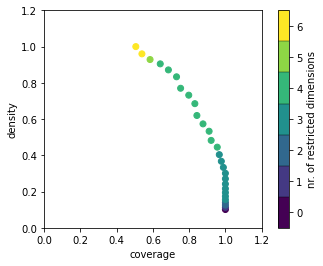

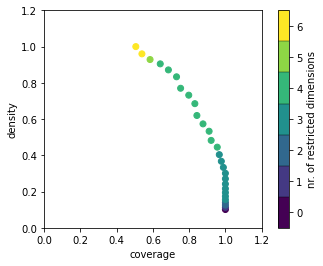

In [24]:
data = raw_data_BL.copy() 
experiments = data.iloc[:, 2:11]
outcomes = data.iloc[:, 15].values

prim_alg = prim.Prim(experiments, outcomes, threshold=0.8, peel_alpha=0.1) #define the prim algorithm 
# if the last box has a density above the threshold, then the analysis is accepted as valuable. Otherwise the analysis isn't accepted 
box1 = prim_alg.find_box() #find the best box 

box1.show_tradeoff()

In [25]:
experiments

,Cellulosic cost,Total biomass,Feedstock distribution,Cellulosic yield,Oil elasticity,Demand elasticity,Electricity coproduction,oil supply shift,Biomass backstop price
0,124.900002,612.799988,0.04,89.500000,0.206,-0.469,1.83,0.078,162.199997
1,67.300003,837.200012,0.18,95.900002,0.277,-0.380,0.01,-0.032,150.300003
2,71.000000,740.400024,0.80,83.500000,0.445,-0.778,0.25,-0.093,135.800003
3,80.099998,995.599976,0.58,82.400002,0.291,-0.334,0.08,-0.086,98.800003
4,76.400002,476.399994,0.79,97.500000,0.443,-0.205,1.59,0.073,163.500000
...,...,...,...,...,...,...,...,...,...
877,99.199997,511.600006,0.45,89.099998,0.363,-0.387,1.75,-0.015,170.500000
878,102.400002,751.400024,0.91,86.800003,0.318,-0.471,0.75,0.023,96.199997
879,100.000000,527.000000,0.59,91.099998,0.410,-0.567,0.22,0.062,137.100006
880,108.300003,694.200012,0.65,99.800003,0.355,-0.368,1.62,0.017,145.399994


[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9


                          reproduce coverage  reproduce density
Total biomass                          100.0              100.0
Demand elasticity                      100.0              100.0
Biomass backstop price                 100.0              100.0
Cellulosic cost                         70.0               70.0
Cellulosic yield                        30.0               30.0
Electricity coproduction                10.0               10.0
Feedstock distribution                   0.0                0.0
Oil elasticity                           0.0                0.0
oil supply shift                         0.0                0.0
coverage    0.730337
density     0.833333
id                22
mass        0.088435
mean        0.833333
res_dim            4
Name: 22, dtype: object

                            box 22                                           
                               min         max                      qp values
Total biomass           450.000000  755.799988  [-1.0

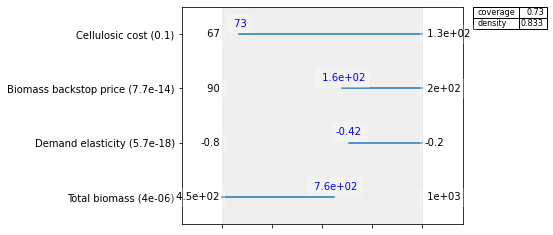

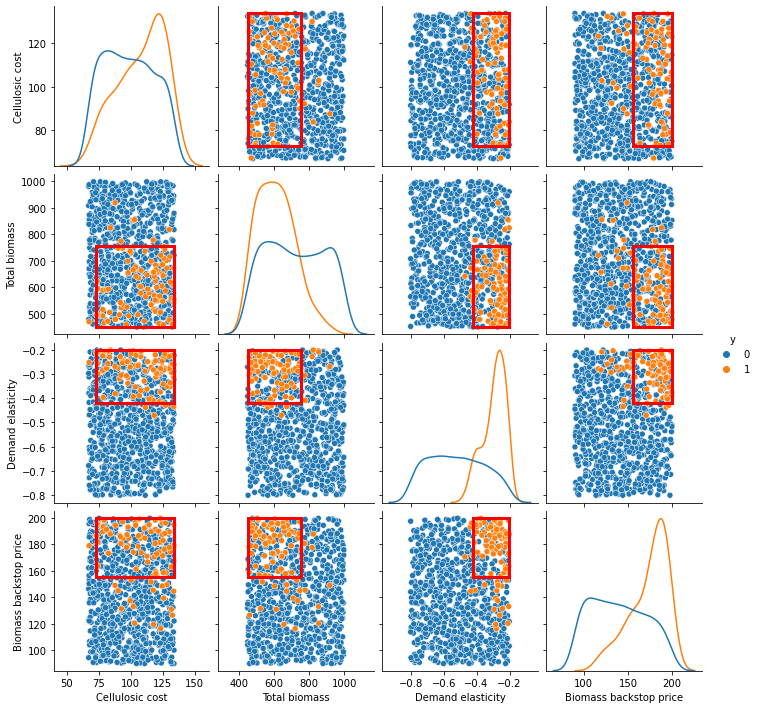

In [6]:
#look at the 21st box 
n_box = 22

print(box1.resample(n_box))
box1.inspect(n_box) 
box1.inspect(n_box, style="graph")
box1.show_pairs_scatter(n_box)

plt.show()

# Rozenberg et al


* The experiments are the first seven columns. The remainder specify whether a given experiment belongs to a given SSP.
* Apply prim separately for each SSP
* you have to play with the threshold for each SSP, the default of 0.8 is at times too high
* if you look at the paper carefully, you will discover that they change some of the default parameters of PRIM


In [7]:
#SSP = subspace partitioning 

In [8]:
raw_data_Roze =  pd.read_csv("data/Rozenberg et al 2014.csv")
print(raw_data_Roze.shape)

raw_data_Roze.head()

(286, 12)


,inequalities,convergence,population,behaviors,technologies,fossils,capital markets,SSP1,SSP2,SSP3,SSP4,SSP5
0,0,2,0,0,0,0,0,0,0,0,0,0
1,0,2,0,0,0,0,1,0,0,0,0,0
2,0,2,0,0,0,1,0,0,0,0,0,0
3,0,2,0,0,0,1,1,0,0,0,0,0
4,0,2,0,0,1,0,0,0,1,0,0,0


In [9]:
data.iloc[:, 0:7]

,renew req %,Pricing,Cellulosic cost,Total biomass,Feedstock distribution,Cellulosic yield,Oil elasticity
0,0.25,1,124.900002,612.799988,0.04,89.500000,0.206
1,0.25,1,67.300003,837.200012,0.18,95.900002,0.277
2,0.25,1,71.000000,740.400024,0.80,83.500000,0.445
3,0.25,1,80.099998,995.599976,0.58,82.400002,0.291
4,0.25,1,76.400002,476.399994,0.79,97.500000,0.443
...,...,...,...,...,...,...,...
877,0.25,1,99.199997,511.600006,0.45,89.099998,0.363
878,0.25,1,102.400002,751.400024,0.91,86.800003,0.318
879,0.25,1,100.000000,527.000000,0.59,91.099998,0.410
880,0.25,1,108.300003,694.200012,0.65,99.800003,0.355


In [10]:
outcomes = pd.DataFrame()

# for i in range(0,5):
#     outcomes = data.iloc[:, 7+i].values
#     prim_alg = prim.Prim(experiments, outcomes, threshold=0.4, peel_alpha=0.01) #define the prim algorithm 
#     box1 = prim_alg.find_box() #find the best box 
#     box1.show_tradeoff()
    

[MainProcess/INFO] 286 points remaining, containing 28 cases of interest
[MainProcess/INFO] mean: 0.5625, mass: 0.055944055944055944, coverage: 0.32142857142857145, density: 0.5625 restricted_dimensions: 4
[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9


                 reproduce coverage  reproduce density
convergence                    80.0               80.0
behaviors                      70.0               70.0
inequalities                   50.0               40.0
population                     40.0               30.0
fossils                        40.0               30.0
capital markets                20.0               20.0
technologies                   10.0                0.0
coverage    0.464286
density     0.270833
id                 3
mass        0.167832
mean        0.270833
res_dim            3
Name: 3, dtype: object

             box 3                                   
               min  max                     qp values
behaviors      0.0  0.0   [-1.0, 0.05034921284527456]
convergence    0.0  1.0   [-1.0, 0.07989762230737826]
inequalities   1.0  1.0  [0.029528663745566577, -1.0]



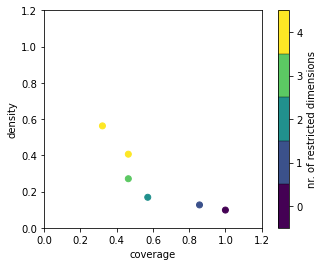

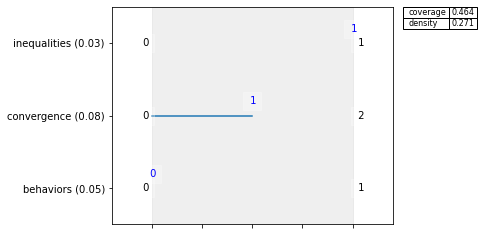

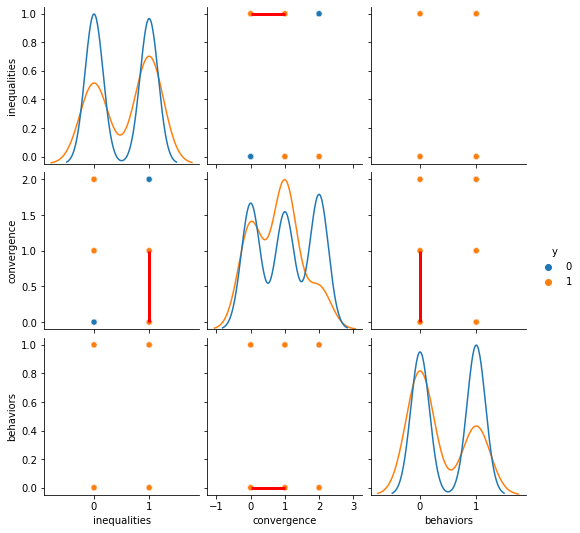

In [11]:
data = raw_data_Roze.copy() 
experiments = data.iloc[:, 0:7]

outcomes = data.iloc[:, 8].values

prim_alg = prim.Prim(experiments, outcomes, threshold=0.5, peel_alpha=0.01) #define the prim algorithm 
box1 = prim_alg.find_box() #find the best box 

box1.show_tradeoff()

#look at the 21st box 
n_box = 3

print(box1.resample(n_box))
box1.inspect(n_box) 
box1.inspect(n_box, style="graph")
box1.show_pairs_scatter(n_box)

plt.show()

# Hamarat et al

this is the most difficult dataset to analyze with prim. It has been generated using the ema_workbench and can be loaded with the `load_results` function. Experiments are of interest if the end state for `'fraction renewables'` is lower than the initial value.

* PRIM struggles with finding a good explanation for this case, why?
* [Dalal et al (2013)](https://www.sciencedirect.com/science/article/pii/S1364815213001345) suggest using PCA preprocessing. The ema_workbench supports this with the `pca_preprocess` function. See also examples/prim_PCA_preprocess.py. Does PCA preprocessing makes a difference for this case?


In [12]:
from ema_workbench.util.utilities import load_results

In [13]:
experiments, outcomes = load_results("data/Hamarat et al 2013.gz")

[MainProcess/INFO] results loaded successfully from /Users/anne-keedoing/Documents/GitHub/epa1361_open/Week 3-4 - vulnerability analysis/data/Hamarat et al 2013.gz


In [14]:
experiments

,SWITCH Market price determination,SWITCH TGC obligation curve,SWITCH carbon cap,SWITCH carbon price determination,SWITCH economic growth,SWITCH electrification rate,SWITCH interconnection capacity expansion,SWITCH lookup curve TGC,SWITCH low reserve margin price markup,SWITCH physical limits,...,starting construction time,time of nuclear power plant ban,uncertainty initial gross fuel costs,weight factor carbon abatement,weight factor marginal investment costs,weight factor technological familiarity,weight factor technological growth potential,year,model,policy
0,1,2,3,2,5,1,1,2,1,2,...,0.813530,2045.490971,0.906060,8.761673,8.859864,4.240532,5.476591,0.939007,energy,no policy
1,2,3,2,1,4,2,1,1,3,2,...,1.712138,2088.839530,0.741120,4.573769,4.300891,4.159390,9.782508,0.964794,energy,no policy
2,1,3,1,1,3,6,4,2,4,1,...,0.390609,2013.876882,1.396959,9.374337,1.586548,2.431839,1.282010,1.070390,energy,no policy
3,2,2,3,2,1,5,1,2,2,1,...,2.069449,2042.566070,1.034850,3.912941,8.038037,1.170614,4.865733,0.979062,energy,no policy
4,1,2,3,3,4,5,1,2,2,1,...,1.094902,2051.277387,0.590479,3.663262,8.602380,7.392188,2.125345,1.073439,energy,no policy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1,1,1,1,3,2,4,1,3,1,...,2.443080,2048.361066,1.382122,8.360590,6.078714,4.943982,1.285286,1.013162,energy,no policy
4996,1,2,3,1,3,5,1,1,2,1,...,1.810992,2046.513779,0.706620,1.436440,4.835751,1.998337,4.328045,0.997881,energy,no policy
4997,1,1,3,1,3,4,1,3,2,1,...,0.524648,2083.535742,1.244429,2.397216,9.297792,1.033138,7.460572,0.903423,energy,no policy
4998,1,3,3,1,6,3,1,1,3,1,...,1.121825,2049.697171,0.585930,2.168406,9.630272,1.098442,9.564640,1.074167,energy,no policy


In [15]:
outcomes['fraction renewables'].shape

(5000, 641)

In [16]:
outcomes['fraction renewables']

array([[0.31618923, 0.31619009, 0.31619254, ..., 0.26765659, 0.26730603,
        0.26695362],
       [0.31508598, 0.31508735, 0.31509113, ..., 0.44931963, 0.44940147,
        0.44947988],
       [0.31839272, 0.31839353, 0.31839618, ..., 0.59941703, 0.59934622,
        0.59928203],
       ...,
       [0.31783172, 0.3178325 , 0.31783482, ..., 0.49547905, 0.49593133,
        0.49639055],
       [0.31375358, 0.31375462, 0.31375748, ..., 0.38203168, 0.3821263 ,
        0.38222334],
       [0.31789917, 0.3179003 , 0.31790349, ..., 0.31051478, 0.3102605 ,
        0.31000748]])

In [17]:
# raw_data_Ha[1].keys()
# raw_data_Ha[1]

In [18]:
# raw_data_Ha[0].columns

In [19]:
data = outcomes['fraction renewables']
y = data[0,:] < data[-1, :]
y_2 = data[:,0] < data[:,-1]
# r1 = outcomes[y1] < t1
# r2 = outcomes[y2] > t2
# r3 = outocmes[y3] < t3
# rc = r1 or (r2 or r3)



In [20]:
len(y_2)
y_2

array([False,  True,  True, ...,  True,  True, False])

In [21]:
experiments['outcome of interest'] = y_2
experiments

,SWITCH Market price determination,SWITCH TGC obligation curve,SWITCH carbon cap,SWITCH carbon price determination,SWITCH economic growth,SWITCH electrification rate,SWITCH interconnection capacity expansion,SWITCH lookup curve TGC,SWITCH low reserve margin price markup,SWITCH physical limits,...,time of nuclear power plant ban,uncertainty initial gross fuel costs,weight factor carbon abatement,weight factor marginal investment costs,weight factor technological familiarity,weight factor technological growth potential,year,model,policy,outcome of interest
0,1,2,3,2,5,1,1,2,1,2,...,2045.490971,0.906060,8.761673,8.859864,4.240532,5.476591,0.939007,energy,no policy,False
1,2,3,2,1,4,2,1,1,3,2,...,2088.839530,0.741120,4.573769,4.300891,4.159390,9.782508,0.964794,energy,no policy,True
2,1,3,1,1,3,6,4,2,4,1,...,2013.876882,1.396959,9.374337,1.586548,2.431839,1.282010,1.070390,energy,no policy,True
3,2,2,3,2,1,5,1,2,2,1,...,2042.566070,1.034850,3.912941,8.038037,1.170614,4.865733,0.979062,energy,no policy,False
4,1,2,3,3,4,5,1,2,2,1,...,2051.277387,0.590479,3.663262,8.602380,7.392188,2.125345,1.073439,energy,no policy,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1,1,1,1,3,2,4,1,3,1,...,2048.361066,1.382122,8.360590,6.078714,4.943982,1.285286,1.013162,energy,no policy,True
4996,1,2,3,1,3,5,1,1,2,1,...,2046.513779,0.706620,1.436440,4.835751,1.998337,4.328045,0.997881,energy,no policy,False
4997,1,1,3,1,3,4,1,3,2,1,...,2083.535742,1.244429,2.397216,9.297792,1.033138,7.460572,0.903423,energy,no policy,True
4998,1,3,3,1,6,3,1,1,3,1,...,2049.697171,0.585930,2.168406,9.630272,1.098442,9.564640,1.074167,energy,no policy,True


[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] 5000 points remaining, containing 4129 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.8258, coverage: 1.0, density: 1.0 restricted_dimensions: 1


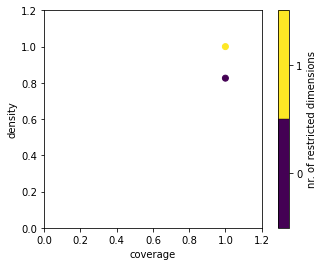

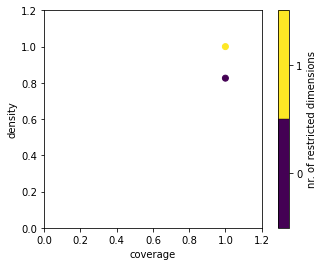

In [22]:
data = raw_data_BL.copy() 
experiment_3 = experiments.iloc[:, 0:642]
outcomes_3 = experiments.iloc[:, -1].values

prim_alg = prim.Prim(experiment_3, outcomes_3, threshold=0.8, peel_alpha=0.1) #define the prim algorithm 
# if the last box has a density above the threshold, then the analysis is accepted as valuable. Otherwise the analysis isn't accepted 
box1 = prim_alg.find_box() #find the best box 

box1.show_tradeoff()